# MNIST database classification
This example is based on the work of quantum neural networks used as classifiers by Farhi et al (https://arxiv.org/abs/1802.06002).

A quantum and a classical neural network are compared on how they can classify pictures that represent two possible handwritten digits (a 3 and a 6).

In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit


## Load the data
We upload the MNIST database from Keras

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))


Number of original training examples: 60000
Number of original test examples: 10000


Now we can filter the pictures that only represent a 3 or a 6 and relabel them for binary classification, such that 3 corresponds to `True` ans 6 to `False`.

In [3]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [4]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))


Number of filtered training examples: 12049
Number of filtered test examples: 1968


True


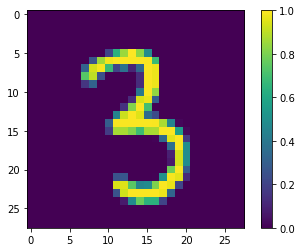

In [5]:
print(y_train[0])

plt.imshow(x_train[29, :, :, 0])
plt.colorbar()


### 1.1 Downscale the image
The images in MNIST are 28x28, which means that they're too big for a quantum device. We rescale them to 4x4

In [6]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()


True


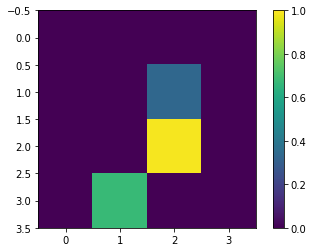

In [7]:
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()


### 1.2 Removing contradictory examples
Because of the pixellation due to going from 28x28 to 4x4, some of the samples corresponding to the same unique picture are labelled sometimes as a 3 and sometimes as a 6. This is contradictory for classifiers and it is handled by the next function.

In [8]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)

    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass

    num_uniq_3 = sum(1 for value in mapping.values() if len(value) == 1 and True in value)
    num_uniq_6 = sum(1 for value in mapping.values() if len(value) == 1 and False in value)
    num_uniq_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of unique 3s: ", num_uniq_3)
    print("Number of unique 6s: ", num_uniq_6)
    print("Number of unique contradicting labels (both 3 and 6): ", num_uniq_both)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))

    return np.array(new_x), np.array(new_y)


In [9]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)


Number of unique images: 10387
Number of unique 3s:  4912
Number of unique 6s:  5426
Number of unique contradicting labels (both 3 and 6):  49

Initial number of images:  12049
Remaining non-contradicting unique images:  10338


### 1.3 Encode the data as quantum circuits
Here we convert the remaining pictures to binary encoding. This uses a threshold, which intuitively means that the pixel is zero or one depending on its intensity being higher or lower than the threshold.

In [10]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

# print(x_train_bin)

In [11]:
_ = remove_contradicting(x_train_bin, y_train_nocon)


Number of unique images: 193
Number of unique 3s:  80
Number of unique 6s:  69
Number of unique contradicting labels (both 3 and 6):  44

Initial number of images:  10338
Remaining non-contradicting unique images:  149


Now we can encode each of the strings (corresponding to images) with a circuit that applies a $X$ gate depending on whethere the bit intensity is higher than a given threshold.

In [12]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


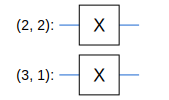

In [13]:
SVGCircuit(x_train_circ[0])


How do we know that the previous circuit properly encodes the bitstring? Well, we can show the indices of the bistring-image which are non-zero.

In [14]:
bin_img = x_train_bin[0,:,:,0]
indices = np.array(np.where(bin_img)).T
indices

array([[2, 2],
       [3, 1]])

Finally, the quantum circuits can be converted to tensors for `tfq`.

In [15]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)
